In [2]:
import pandas as pd
import numpy as np

In [3]:
def haversine_np(
    lon1: float, lat1: float, lon2: float, lat2: float
) -> np.array:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = (
        np.sin(dlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    )

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

In [4]:
def raw_data( val: int) -> pd.DataFrame:
    quert_st_id1 = seoul_bike[seoul_bike["st_id1"] == val]
    quert_st_id2 = seoul_bike[seoul_bike["st_id2"] == val]
    filtered_data = pd.concat(
        [quert_st_id1, quert_st_id2], axis=0
    ).drop_duplicates()
    filtered_data.drop(columns="index", inplace=True)
    bm = (filtered_data["st_id1"] == val) & (filtered_data["st_id2"] == val)
    filtered_data = filtered_data[~bm]

    # # 반납
    # filtered_data_end = filtered_data[
    #     (filtered_data["st_id2"] == val) & (filtered_data["st_id1"] != val)
    # ]

    return filtered_data

In [5]:
station = pd.read_csv(
    "assets/seoul_bike_station_01_12.csv", encoding="CP949", index_col=0
)

near_bus = pd.read_csv(
    "assets/near_bus_500m.csv", encoding="CP949", index_col=0
)

seoul_bike = pd.read_parquet("/Users/yangwoolee/git_repo/seoulBikeProject/parquet/220607_bike_record.parquet.gzip")

sub_info = pd.read_csv(
    "assets/sub_and_bike_info.csv", encoding="CP949", index_col=0
)

search_info = pd.read_csv(
    "assets/search_info.csv", encoding="CP949", index_col=0
)
btstation = pd.read_csv(
    "assets/btbtstation_info.csv", encoding="CP949", index_col=0
)

near_sub = pd.read_csv(
    "assets/near_sub_station.csv", encoding="CP949", index_col=0
)

### 전체 상호작용 중 대여기록이 50건 이상인 상호작용은 얼마나 될까?

In [6]:
# def findInteractionNum(id:int) :
def stationInteraction(id:int) :
    stationInteraction = seoul_bike[seoul_bike["st_id1"] == id ].groupby(by='st_id2').size()

    data = stationInteraction[stationInteraction>=50].sort_values(ascending=False)
    result = pd.DataFrame(data).reset_index(drop=False)
    result['st_id1']= id
    result = result[['st_id1','st_id2',0]]
    return result

## 전체 대여소간 대여상호작용을 리스트로 그림 
listDataFrame = list(map(stationInteraction,station.index))

In [10]:
Interactions = pd.concat(listDataFrame)
counts = Interactions[0]

In [11]:
len(counts)/len(station)

37.68958966565349

In [21]:
Interactions

,st_id1,st_id2,0
0,102,102,3100
1,102,107,1990
2,102,152,1925
3,102,184,1596
4,102,154,1127
...,...,...,...
1,2714,1152,83
2,2714,2715,81
3,2714,1153,76
4,2714,2701,69


<AxesSubplot:ylabel='Frequency'>

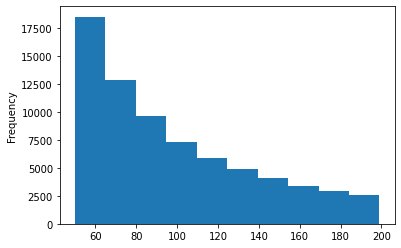

In [18]:
# counts[ counts > counts.quantile(q=0.90)].plot.hist(bins=30)
# counts[ (counts > 100) & (counts < 2500)].plot.hist(bins=10)
counts[counts < 200].plot.hist(bins=10)

### 끝

In [6]:
def findNearBus(id:int) ->pd.DataFrame :
    #bikeStation
    k = station[station.index == id]

    #haversine 계산
    tLong = k['longtitude'].values
    tLat = k['latitude'].values
    bLong=near_bus['longtitude']
    bLat=near_bus['latitude']
    dist = haversine_np(tLong,tLat,bLong,bLat)

    #column에 포함
    nearBusCopy = near_bus.copy()
    nearBusCopy['dist'] = dist
    busSort = nearBusCopy[dist <= 4000]

    # 이용가능한 bus Df만들기
    busNums = busSort['bus'].unique().tolist()
    val = [busSort[busSort['bus']==busNum].sort_values(by='dist',ascending=True).iloc[0] for busNum in busNums]
    busInfoNear4000 = pd.concat(val,axis=1).T.sort_values(by='dist',ascending=True)
    return busInfoNear4000

In [7]:
def findNearSub(id:int) -> pd.DataFrame :
    k = station[station.index == id]
    tLong = k['longtitude'].values
    tLat = k['latitude'].values
    bLong=sub_info['longtitude']
    bLat=sub_info['latitude']
    dist = haversine_np(tLong,tLat,bLong,bLat)

    #column에 포함
    subInfoCopy = sub_info.copy()
    subInfoCopy['dist'] = dist
    subSort = subInfoCopy[dist <= 4000]
    subNames = subSort['sub_name'].unique().tolist()
    val = [subSort[subSort['sub_name']==subName].sort_values(by='dist',ascending=True).iloc[0] for subName in subNames]
    subInfoNear4000 = pd.concat(val,axis=1).T.sort_values(by='dist',ascending=True)
    return subInfoNear4000


In [19]:
def findNearBike(id:int,rawData:pd.DataFrame) -> pd.DataFrame :
    k = station[station.index == id]
    tLong = k['longtitude'].values
    tLat = k['latitude'].values
    bLong=station['longtitude']
    bLat=station['latitude']
    dist = haversine_np(tLong,tLat,bLong,bLat)

    subInfoCopy = station.copy()
    subInfoCopy['dist'] = dist
    bikeSort = subInfoCopy[(dist <= 4000) & (dist >= 1000)]

    top20 = rawData['st_id1'].value_counts()[:30].index.tolist()
    bikeSort = bikeSort[bikeSort.index.isin(top20)].reset_index()
    return bikeSort



In [28]:
id = 754
val = raw_data(id)
bike = findNearBike(id, val)
bus = findNearBus(id)
sub = findNearSub(id)